__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

13062


,title,adr,latitude,longitude,priceM,ts
3486,Участок 10 сот. (ИЖС),"Севастополь,ТСН СТ Дружба",44.59,33.59,4.00,2022-09-15 10:31:26.039
12786,Участок 6 сот. (ИЖС),"Севастополь,Фортификационная ул., 100к100",44.495151,33.614356,2.00,2022-11-04 17:12:55.140
12750,Участок 8 сот. (ИЖС),"Севастополь,с. Орловка",44.73,33.59,1.85,2022-11-04 17:12:55.140


In [6]:
# df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [7]:
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13062 entries, 0 to 13061
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               13062 non-null  object        
 1   price               13062 non-null  int64         
 2   obj_name            13062 non-null  object        
 3   adr_orig            13062 non-null  object        
 4   description         13062 non-null  object        
 5   avito_page          13062 non-null  int64         
 6   ts                  13062 non-null  datetime64[ns]
 7   place               13062 non-null  object        
 8   area                13062 non-null  float64       
 9   is_IJS              13062 non-null  bool          
 10  priceM              13062 non-null  float64       
 11  priceMU             13062 non-null  float64       
 12  area_size_category  13057 non-null  category      
 13  url                 13062 non-null  object    

In [9]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
7475,Участок 5 сот. (ИЖС),"Севастополь,пос. городского типа Кача, ул. Константина Арцеулова",44.770433,33.55381,2.00,2022-09-22 09:57:15.623
3871,"Участок 1,8 сот. (ИЖС)","Севастополь,пр-т Генерала Острякова",44.568475,33.523222,1.80,2022-09-15 10:31:26.039
3100,Участок 6 сот. (ИЖС),"Севастополь,Инкерман, садоводческое товарищество Коррида, 25",44.645726,33.613278,3.30,2022-09-13 13:56:54.600


In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

13062
13049


### ограничиваем тип объекта 

In [11]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
4332,Участок 8 сот. (ИЖС),"Севастополь,с. Угловое, ул. Шкребко, 29",44.814403,33.616269,2.70
9536,Участок 4 сот. (ИЖС),"Севастополь,СНТ Сапун-гора, 1802",44.571268,33.570967,5.30
5409,Участок 5 сот. (ИЖС),"Севастополь,Нахимовский район",44.70,33.65,2.50


In [13]:
del df

In [14]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [15]:
ts = '2022-08-01' # ограничиваем дату

In [16]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
)
stat

count  mean   std  min   1%  10%   25%   50%  \
area_size_category dt                                                         
<1                 2022-09-08   2.00  8.07  9.79 1.15 1.29 2.53  4.61  8.07   
                   2022-09-12   2.00  8.07  9.79 1.15 1.29 2.53  4.61  8.07   
                   2022-09-13   2.00  8.07  9.79 1.15 1.29 2.53  4.61  8.07   
                   2022-09-15   2.00  8.07  9.79 1.15 1.29 2.53  4.61  8.07   
                   2022-09-16   2.00  8.07  9.79 1.15 1.29 2.53  4.61  8.07   
...                              ...   ...   ...  ...  ...  ...   ...   ...   
20+                2022-09-26  40.00 30.46 30.36 1.55 1.76 2.99  8.82 18.50   
                   2022-10-08  31.00 26.61 25.37 1.55 1.61 3.00  7.90 16.50   
                   2022-10-14  27.00 28.37 24.34 3.00 3.52 6.30 12.00 18.00   
                   2022-11-01  37.00 29.07 29.15 1.50 1.50 2.34  7.50 18.00   
                   2022-11-04  33.00 30.70 29.06 1.50 1.50 3.40  9.98 18.00   

                                75%   90%    max  
area_size_category dt                             
<1                 2022-09-08 11.54 13.61  15.00  
                   2022-09-12 11.54 13.61  15.00  
                   2022-09-13 11.54 13.61  15.00  
                   2022-09-15 11.54 13.61  15.00  
                   2022-09-16 11.54 13.61  15.00  
...                             ...   ...    ...  
20+                2022-09-26 38.50 71.40 120.00  
                   2022-10-08 36.00 71.00  90.00  
                   2022-10-14 36.00 68.80  90.00  
                   2022-11-01 38.00 70.40 125.00  
                   2022-11-04 40.00 69.60 125.00  

[72 rows x 11 columns]

In [18]:
( # количество предложений
    gdf.query('priceM>1.')
    .groupby(['area_size_category'])
    [['title']].count()
).T

area_size_category,<1,1-2,2-4,4-8,8-20,20+
title,23,37,1764,6437,4062,430


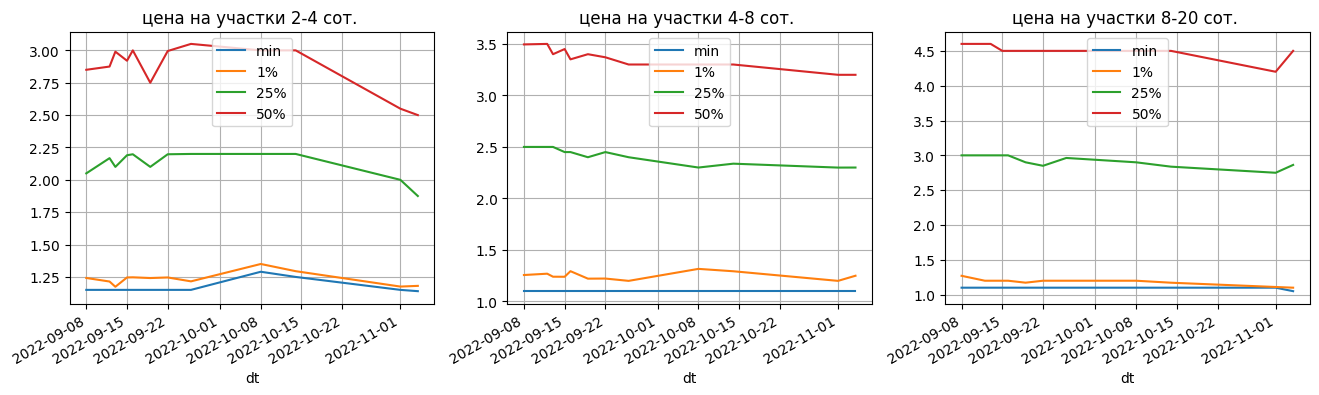

In [20]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]

# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,['min','1%','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### район поиска

In [21]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

### гексагональная сетка

In [22]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [23]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
7,862d2884fffffff,"POLYGON ((33.78229 44.62555, 33.76080 44.59617, 33.78760 44.56734, 33.83587 44.56788, 33.85737 44.59725, 33.83059 44.62609, 33.78229 44.62555))"
23,862d2895fffffff,"POLYGON ((33.56756 44.59377, 33.54614 44.56432, 33.57303 44.53552, 33.62132 44.53616, 33.64275 44.56559, 33.61589 44.59440, 33.56756 44.59377))"


### медиана актуальной цены

In [24]:
# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [25]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [26]:
frames.explore('area_name')

In [27]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

13049
434


In [28]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[gdf_['ts']>ts][cols].explore( 'area_size_category',legend=True)

### изменение цены

In [30]:
( # количество предложений
    gdf_.query('priceM>1.')
    .groupby(['area_size_category'])
    [['title']].count()
).T

area_size_category,<1,1-2,2-4,4-8,8-20,20+
title,0,0,61,266,100,7


In [34]:
stat = (
    gdf_.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
)
stat

count   mean  std    min     1%    10%    25%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.60   2.62   2.64   
                   2022-09-12   4.00   2.91 0.53   2.60   2.60   2.62   2.64   
                   2022-09-13   4.00   2.91 0.53   2.60   2.60   2.62   2.64   
                   2022-09-15   4.00   2.91 0.53   2.60   2.60   2.62   2.64   
                   2022-09-16   5.00   2.85 0.48   2.60   2.60   2.60   2.60   
                   2022-09-19   5.00   2.85 0.48   2.60   2.60   2.60   2.60   
                   2022-09-22   5.00   2.85 0.48   2.60   2.60   2.60   2.60   
                   2022-09-26   4.00   2.91 0.53   2.60   2.60   2.61   2.64   
                   2022-10-08   5.00   2.84 0.55   2.25   2.26   2.39   2.60   
                   2022-10-14   5.00   2.76 0.62   2.20   2.20   2.22   2.25   
                   2022-11-01   8.00   2.62 0.53   2.10   2.11   2.17   2.24   
                   2022-11-04   8.00   2.62 0.53   2.00   2.01   2.14   2.31   
4-8                2022-09-08  22.00   3.75 2.17   1.60   1.64   2.00   2.23   
                   2022-09-12  25.00   3.48 1.89   1.45   1.47   1.80   2.20   
                   2022-09-13  24.00   3.27 1.61   1.45   1.47   1.80   2.20   
                   2022-09-15  25.00   3.21 1.61   1.45   1.47   1.80   2.20   
                   2022-09-16  24.00   3.30 1.67   1.45   1.47   1.80   2.15   
                   2022-09-19  24.00   3.35 1.67   1.45   1.47   1.80   2.15   
                   2022-09-22  27.00   3.31 1.65   1.45   1.48   1.70   2.10   
                   2022-09-26  22.00   3.21 1.54   1.55   1.55   1.80   2.20   
                   2022-10-08  20.00   3.54 1.49   1.80   1.80   2.16   2.27   
                   2022-10-14  18.00   3.62 1.52   1.80   1.87   2.20   2.35   
                   2022-11-01  19.00   3.53 1.56   1.80   1.84   2.16   2.30   
                   2022-11-04  16.00   3.28 1.45   1.80   1.82   1.98   2.27   
8-20               2022-09-08   9.00   6.02 5.10   1.65   1.72   2.33   3.10   
                   2022-09-12   8.00   6.21 4.71   1.65   1.75   2.67   3.18   
                   2022-09-13   9.00   6.43 4.45   1.65   1.77   2.81   3.20   
                   2022-09-15  10.00   5.44 4.46   1.65   1.69   2.10   2.72   
                   2022-09-16   9.00   5.76 4.61   1.65   1.69   2.05   3.10   
                   2022-09-19   9.00   5.76 4.61   1.65   1.69   2.05   3.10   
                   2022-09-22   9.00   6.26 5.54   1.65   1.69   2.05   3.00   
                   2022-09-26  10.00   5.77 4.76   1.65   1.69   2.10   3.02   
                   2022-10-08   6.00   4.25 1.16   2.90   2.90   2.95   3.25   
                   2022-10-14   8.00   5.67 3.90   2.90   2.91   2.97   3.75   
                   2022-11-01   7.00   5.70 4.17   2.90   2.94   3.26   3.75   
                   2022-11-04   6.00   5.98 4.49   2.90   2.93   3.20   3.83   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-15   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-16   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-19   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-22   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 50%    75%    90%    max  
area_size_category dt                                      
2-4                2022-09-08   2.67   2.95   3.40   3.70  
                   2022-09-12   2.67   2.95   3.40   3.70  
                   2022-09-13   2.67   2.95   3.40   3.70  
                   2022-09-15   2.67   2.95   3.40   3.70  
                   2022-09-16   2.65   2.70   3.30   3.70  
          

In [36]:
# gdf_['area_size_category'].unique()

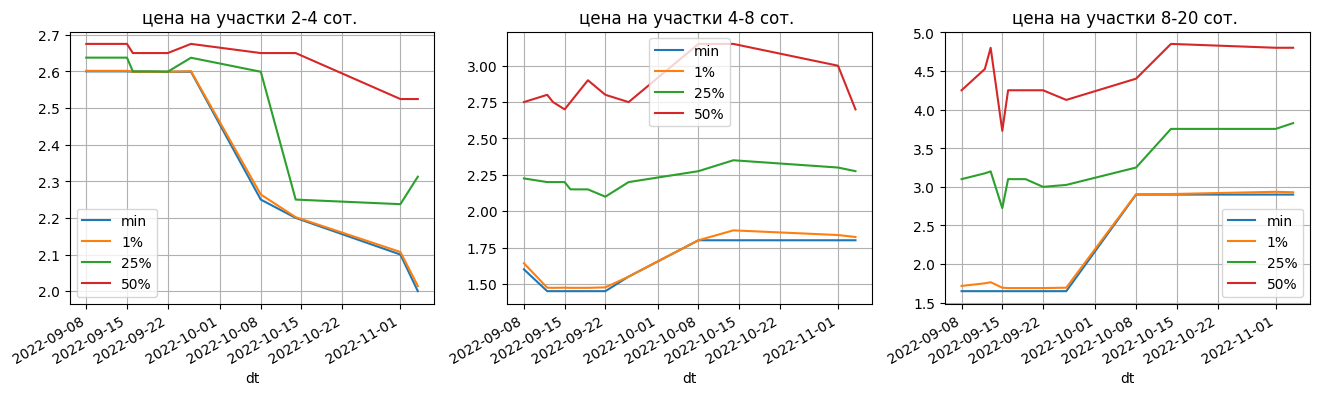

In [37]:
import matplotlib.pyplot as plt

# sizes = gdf_['area_size_category'].unique()
# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False )
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[s,['min','1%','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### гексагональная сетка

In [38]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
7,892d2895c97ffff,"POLYGON ((33.54842 44.57685, 33.54809 44.57506, 33.55018 44.57390, 33.55259 44.57453, 33.55291 44.57632, 33.55083 44.57748, 33.54842 44.57685))"
1,892d289438bffff,"POLYGON ((33.53962 44.59161, 33.53929 44.58982, 33.54138 44.58866, 33.54379 44.58929, 33.54411 44.59107, 33.54203 44.59224, 33.53962 44.59161))"


### медиана актуальной цены

In [39]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [ ]:
# gdf[['latitude','longitude']].max()

# min
# latitude    43.23
# longitude   33.40

# max
# latitude    44.90
# longitude   34.19

In [ ]:
# from shapely.geometry import Point

# gpd.GeoDataFrame(
#     {'pos':['min','max']},
#     geometry=gpd.points_from_xy( [33.40,34.19], [43.23,44.90]),
#     crs='epsg:4326',
# ).explore()